
# Double Learning
Reference
- [DataHubbs Blog](https://www.datahubbs.com/double-q-learning/)
- [YouTube link: Reinforcement Learning - Lecture 17 (Double Q Learning & Maximization Bias ~Programming in Python)](https://www.youtube.com/watch?v=FlQJ6Oo1Y8Q)


## Maximization Bias
We have discussed algorithms, Sarsa and Q-learning, that involve **maximization** in the construction of their target policies.
- Q-learning : the target policy is the greedy policy.
- Sarsa : the target policy (= the behavior policy) is often $\epsilon$-greedy policy, which also involves maximization.

In these algorithms, a maximum over estimated values is used implicitly as an estimate of the maximum value, which can lead to a significant positive bias. 
- We call the bias **maximization bias** or overestimation bias.
- We will see how such a bias can be introduced by the following example.
    - Example 6.7 of [Sutton & Barto, 2020].
    - Figure 6.5

<center><img src="./simpleMDP.png" width="500" height="150"></center>

The above image shows a small MDP.
- Two non-terminal states `A` and `B`.
- Episodes always start in `A` with a choice between two actions, `left` and `right`.
    - The `right` action transitions immediately to the terminal state with a **reward and return of zero**.
    - The `left` action transitions to `B`, also with a **reward of zero**.
- In the state `B`, there are **many possible actions** all of which cause immediate termination with **a reward** drawn from $\mathcal{N}(-0.1, 1)$.

The expected return for any trajectory starting from `left` is $-0.1$.
- Taking `left` in state `A` is always a mistake.
- However, because of the randomness of reward, the agent can be fooled by some samples that obtained positive rewards.
- Hence, in the beginning of learning, the algorithms may favor `left` because of maximization bias making `B` appear to have a positive value.

The following figure explains that the maximization bias indeed occurs.

<center><img src="./figure.png" width="600" height="310"></center>

Assumptions for the experiment
- The data are averaged over 10,000 runs.
- The initial action-value estimates were zero.
- Any ties in $\epsilon$-greedy action selection were broken randomly.

Notice that maximization bias would not occur in the environment with deterministic dynamics. (deterministic reward and deterministic transitions)
- When the rewards are deterministic but the state transitions are stochastic, the same pattern of overestimations due to this noise can occur.

## How to avoid maximization bias?

One way to view the problem is that it is due to using the same samples both to determine the maximizing action and to estimate its value.
- Assume that we construct two unbiased estimators $Q_1(s,a)$ and $Q_2(s,a)$ for the true value $q(s,a)$.
- At the state $s$, 
    - we can determine the maximizing action $A^\ast = \arg\max_a Q_1(s,a)$, and
    - we can use $Q_2$ to provide the estimate of its value $Q_2(s,A^\ast) = Q_2(s, \arg\max_a Q_1(s,a))$.
- Then, by the assumption of unbiasedness, we have $\mathbb{E}[Q_2(s,A^\ast)]=q(s,A^\ast)$. Hence, the estimate is again unbiased.

This idea is called `double learning`. 
- Notes
    - Although we learn two estimates, only one estimate is updated on each play.
    - Double learning doubles the memory requirements, but does not increase the amount of computation per step.

The following is the double learning algorithm analogous to Q-learing, called Double Q-learning.
- The tables $Q_1$ and $Q_2$ are treated completely symmetrically.
- There are also double versions of Sarsa and Expected Sarsa.

<center><img src="./double_q_learning.png" width="800" height="350"></center>


## Implementation of the MDP

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
class simpleMDP():
    def __init__(self):

        # Observation space
        self.start_state = 'A'
        self.terminal_state = 'T'
        self.states = ['A', 'B', 'T']

        # Action space
        self.b_actions = list(range(1,10))
        self.possible_actions = {
            'A' : ['left', 'right'],
            'B' : self.b_actions,
            'T' : []
        }

        # Transitions
        self.state_transitions = {('B', i): 'T' for i in self.b_actions}
        self.state_transitions[('A', 'left')] = 'B'
        self.state_transitions[('A', 'right')] = 'T'

        # To save the current state
        self.state = 'A'

    def reward(self, state, action):
        # reward function
        if (state == 'B'):
            mu, sigma = -0.1, 1
            return np.random.normal(mu,sigma,1)[0]
        return 0
    
    def reset(self):
        self.state = 'A'
        return self.state
    
    def step(self, action):
        reward = self.reward(self.state, action)
        self.state = self.state_transitions[(self.state, action)]
        done = (self.state == self.terminal_state)
        return self.state, reward, done
    
    def available_actions(self, state=None):
        if state is None:
            return self.possible_actions[self.state]
        else:
            return self.possible_actions[state]
    
    def sample_actions(self, state=None):
        return np.random.choice(self.available_actions(state))
    

## Q-learning

In [3]:
env = simpleMDP()

max_tests = 10000
MAX_EPISODE = 300
EPSILON = 0.1
GAMMA = 1
alpha = 0.1

left_count_q = np.zeros(MAX_EPISODE)
q_estimate = np.zeros(MAX_EPISODE)
t = 0

while t < max_tests:
    Q = {'A' : {'left' : 0, 'right' : 0},
         'B' : {a : 0 for a in env.b_actions},
         'T' : {None : 0}
        }
    for episode in range(MAX_EPISODE):
        done = False
        state = env.reset()

        while not done:
            if np.random.uniform() < EPSILON:
                action = env.sample_actions(state)
            else:
                # If there are more than two actions that maximizes the Q-value, choose randomly between them.
                max_q = max(Q[state].values())
                max_actions = [k for k in Q[state].keys() if Q[state][k] == max_q]
                action = np.random.choice(max_actions)
            
            if state == 'A' and action == 'left':
                left_count_q[episode] += 1
            
            next_state, reward, done = env.step(action)
            
            # Update Q-tables
            Q[state][action] += alpha * (reward + GAMMA * max(Q[next_state].values()) - Q[state][action])

            if done:
                q_estimate[episode] += (Q['A']['left'] - q_estimate[episode]) / (episode+1)

            state = next_state

    t+= 1


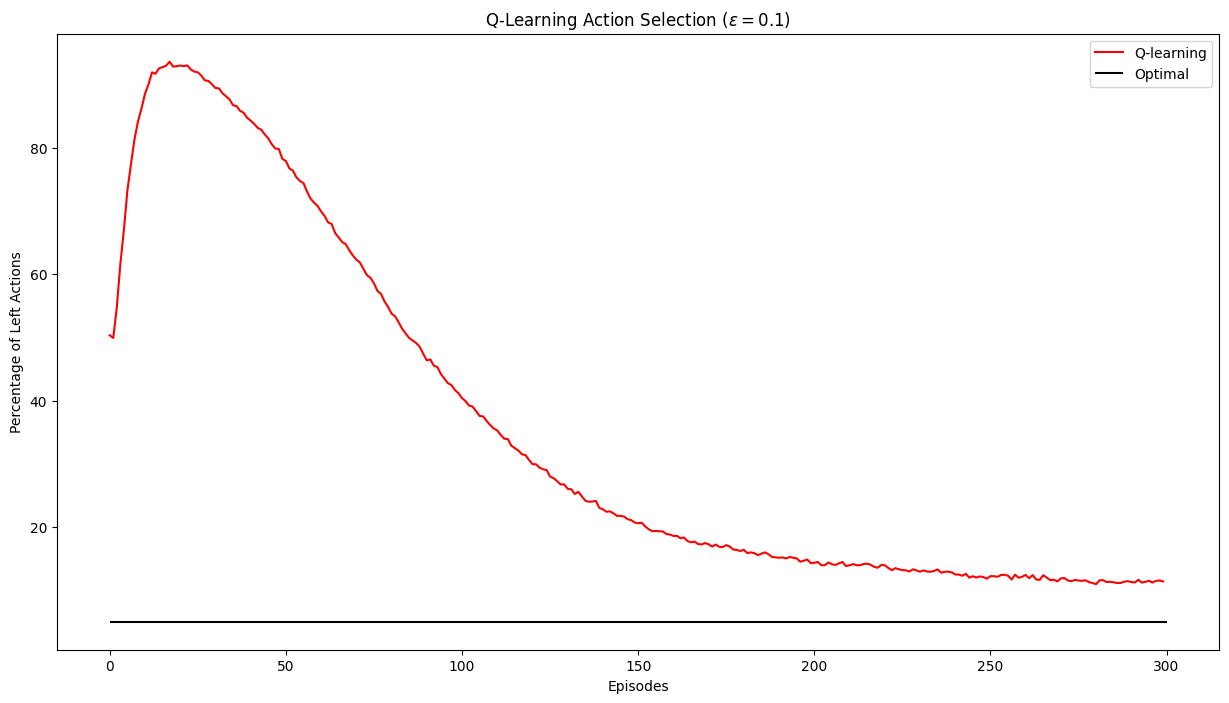

In [4]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(MAX_EPISODE), left_count_q/max_tests*100, 'r-', label='Q-learning')
plt.hlines(xmin=0, xmax=MAX_EPISODE, y=EPSILON/2 * 100, label='Optimal', colors='k')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()


## Double Q-learning

In [5]:
env = simpleMDP()

max_tests = 10000
MAX_EPISODE = 300
EPSILON = 0.1
GAMMA = 1
alpha = 0.1

left_count_dq = np.zeros(MAX_EPISODE)
q1_estimate = np.zeros(MAX_EPISODE)
q2_estimate = np.zeros(MAX_EPISODE)
t = 0

while t < max_tests:
    Q1 = {'A' : {'left' : 0, 'right' : 0},
         'B' : {a : 0 for a in env.b_actions},
         'T' : {None : 0}
        }
    Q2 = {'A' : {'left' : 0, 'right' : 0},
         'B' : {a : 0 for a in env.b_actions},
         'T' : {None : 0}
        }
    
    for episode in range(MAX_EPISODE):
        done = False
        state = env.reset()

        while not done:
            if np.random.uniform() < EPSILON:
                action = env.sample_actions(state)
            else:
                # If there are more than two actions that maximizes the Q-value, choose randomly between them.
                Q_state_sum = {}
                for act in Q1[state].keys():
                    Q_state_sum[act] = Q1[state][act] + Q2[state][act]
                max_q = max(Q_state_sum.values())
                max_actions = [k for k in Q_state_sum.keys() if Q_state_sum[k] == max_q]
                action = np.random.choice(max_actions)
            
            if state == 'A' and action == 'left':
                left_count_dq[episode] += 1
            
            next_state, reward, done = env.step(action)
            
            # Update Q-tables
            if np.random.uniform() < 0.5:
                max_q = max(Q1[next_state].values())
                max_actions = [k for k in Q1[next_state].keys() if Q1[next_state][k] == max_q]
                target_action = np.random.choice(max_actions)

                Q1[state][action] += alpha * (reward + GAMMA * Q2[next_state][target_action] - Q1[state][action])
            
            else:
                max_q = max(Q2[next_state].values())
                max_actions = [k for k in Q2[next_state].keys() if Q2[next_state][k] == max_q]
                target_action = np.random.choice(max_actions)

                Q2[state][action] += alpha * (reward + GAMMA * Q1[next_state][target_action] - Q2[state][action])

            if done:
                q1_estimate[episode] += (Q1['A']['left'] - q1_estimate[episode]) / (episode+1)
                q2_estimate[episode] += (Q2['A']['left'] - q2_estimate[episode]) / (episode+1)

            state = next_state

    t+= 1


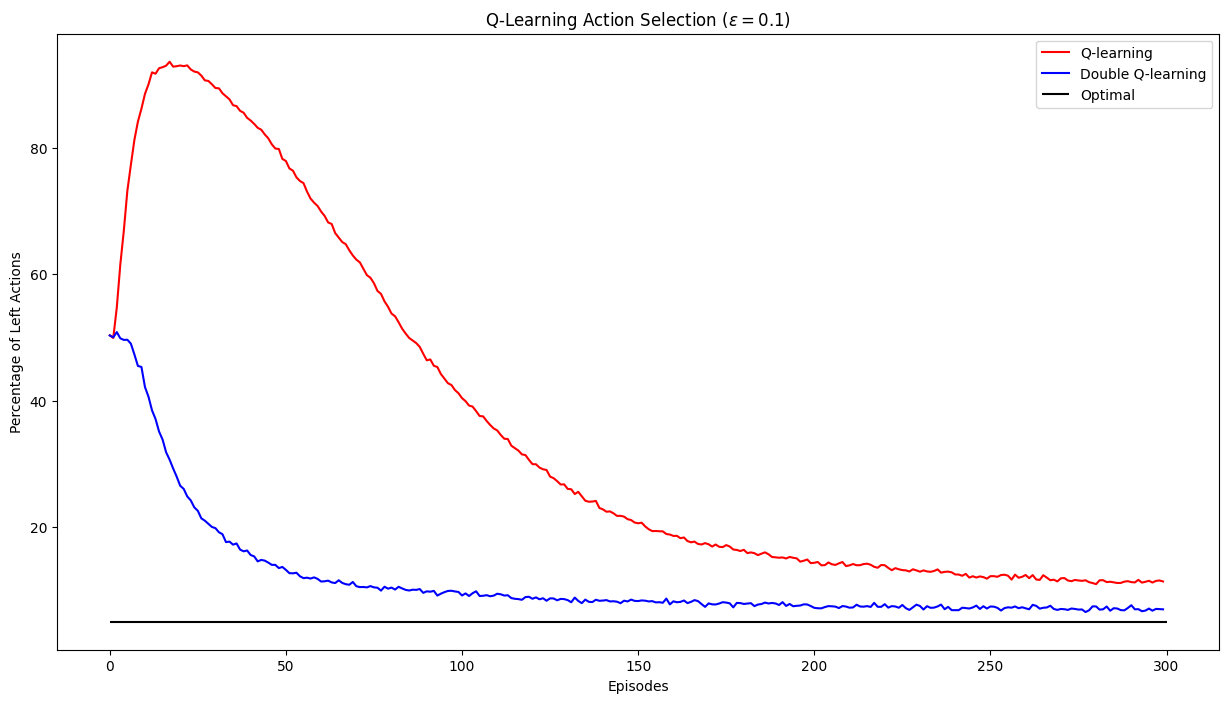

In [8]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(MAX_EPISODE), left_count_q/max_tests*100, 'r-', label='Q-learning')
plt.plot(np.arange(MAX_EPISODE), left_count_dq/max_tests*100, 'b-', label='Double Q-learning')
plt.hlines(xmin=0, xmax=MAX_EPISODE, y=EPSILON/2 * 100, label='Optimal', colors='k')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()

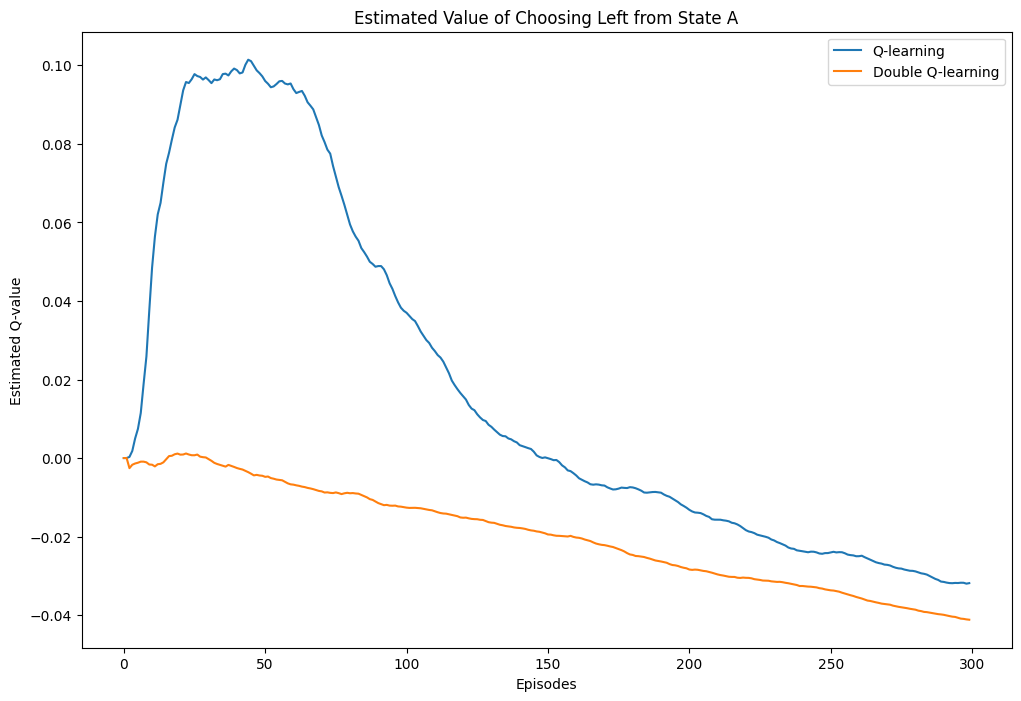

In [7]:
mean_q_estimate = (q1_estimate + q2_estimate) / 2
plt.figure(figsize=(12,8))
plt.plot(q_estimate, label='Q-learning')
plt.plot(mean_q_estimate, label='Double Q-learning')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Estimated Q-value')
plt.title('Estimated Value of Choosing Left from State A')
plt.show()